In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

In [3]:
# Dataset
xor_inputs = np.array([[0.01, 0.01],
                       [0.01, 0.99],
                       [0.99, 0.01],
                       [0.99, 0.99]])

xor_targets = np.array([[0.01],
                        [0.99],
                        [0.99],
                        [0.01]])

In [4]:
class Layer:
    
    """
    Create a new Layer object which represents a single layer
    in NeuralNetwork class. Layer object stores information
    about its weights, biases and their gradients.

    Parameters
    ----------
    
        num_previous_neurons : int
            Number of neurons in the previous layer

        num_current_neurons : int
           Number of neurons in the next layer
    
    Public methods defined here
    ---------------------------
    
        forward_pass(self, A_p)
            Calculates activations of the current Layer object.

        backward_pass(self, A_p, D_c)
            Calculates gradient of the current Layer object's weights and biases and sets respective attributes.

        update(self, lr)
            Updates current Layer object's weights and biases.
    """

    def __init__(self, num_previous_neurons, num_current_neurons):
        
        # Weights between the previous layer and the current one
        self.W = np.random.uniform(size=(num_previous_neurons, num_current_neurons))
        # Biases leading to the current layer
        self.B = np.random.uniform(size=(1, num_current_neurons))
        # Gradients are only calculated during backpropagation
        self.nabla_W = None
        self.nabla_B = None
    
    def __sigm(self, Z):
        
        """
        Sigmoid activation function.

        Parameters
        ----------
        
            Z : numpy.ndarray
                Vector of numbers

        Returns
        -------
        
            out : numpy.ndarray
                The same vector with sigmoid function applied
        """
        
        return 1 / (1 + np.exp(-Z))
    
    def forward_pass(self, A_p):
        
        """
        Calculates activations of the current layer.

        Parameters
        ----------
        
            A_p : numpy.ndarray
                Vector of activations of the previous layer

        Returns
        -------
        
            out : numpy.ndarray
                Vector of activations of the current layer
        """
        
        return self.__sigm(A_p @ self.W + self.B)
    
    def backward_pass(self, A_p, D_c):
        
        """
        Calculates gradient of the current layer's parameteres and sets respective attributes.

        Parameters
        ----------
        
            A_p : numpy.ndarray
                Vector of activations of the previous layer

            D_c : numpy.ndarray
                Delta of the current layer
        
        Returns
        -------
        
            out : None
        """
        
        self.nabla_W = A_p.T @ D_c
        self.nabla_B = np.sum(D_c, axis=0)
    
    def update(self, lr):
        
        """
        Updates parameters.

        Parameters
        ----------
        
            lr : float
                Learning rate

        Returns
        -------
        
            out : None
        """
        
        self.W -= lr * self.nabla_W
        self.B -= lr * self.nabla_B

In [5]:
class NeuralNetwork:
        
    """
    Create a NeuralNetwork object of arbitrary size.
    Each layer is represented by object of Layer class
    which stores information about weights, biases and
    their gradients.

    Parameters
    ----------
    
        size : str
            String of type 'A:B:...:C' where numbers A, B, ..., C represent amount of neurons in successive layers

        A_0 : numpy.ndarray
           Vector of explanatory variables / Inputs for the nnet / Input layer's activations
           
        T : numpy.ndarray
           Vector of response variables / Expected outputs
           
        lr : float
           Learning rate
    
    Public methods defined here
    ---------------------------
    
        fit(self, epochs)
            Trains neural network on the given dataset.
        
        get_output(self)
            Returns last layer's activations.

        mse(self, accuracy=10)
            Returns mean squared error with specified accuracy.
            
        scatter(self, error=0.2, save=False)
            Plots the scatter diagram.
    """

    def __init__(self, size, A_0, T, lr=0.5):
        
        # Initializing self.__layers attribute
        self.__set_size(size)
        # Inputs for the nnet
        self.A_0 = A_0
        # Expected outputs
        self.T = T
        # Learning rate
        self.lr = lr
    
    def __set_size(self, size):
        
        """
        Sets __layers atribute according to the given size of the network.

        Parameters
        ----------
        
            size : str
                String of type 'A:B:...:C'

        Returns
        -------
        
            out : None
        """
        
        layer_sizes = [int(char) for char in size if char.isdigit()]
        self.__layers = []
        for num_layer in range(1, len(layer_sizes)):
            num_previous_neurons = layer_sizes[num_layer-1]
            num_current_neurons = layer_sizes[num_layer]
            self.__layers.append(Layer(num_previous_neurons, num_current_neurons))
    
    def __forward_propagation(self):
        
        """
        Calculates each layer's activations and plugs them into a newly initialized list attribute called __A.

        Returns
        -------
        
            out : None
        """
        
        # Plugging first layer activations (i.e. inputs of network)
        # into a list of all activations of neural network
        self.__A = [self.A_0]
        # Computing activations of remaining layers
        for layer in self.__layers:
            # Activations A_p of previous layer is
            # the last item in the list of activations
            A_p = self.__A[-1]
            # Calculating activations of current layer and adding it
            # to the end of the list of activations so that next
            # layer could use it as previous layer activations
            self.__A.append(layer.forward_pass(A_p))

    def __backward_propagation(self):
        
        """
        Calculates each layer's gradient and sets their respective attributes nabla_W and nabla_B.

        Returns
        -------
        
            out : None
        """
        
        # List of layers' deltas
        D = []
        # Layers and activations in reverse order
        # so as to going backwards from the last layer
        layers_reverse = self.__layers[::-1]
        A_reverse = self.__A[::-1]
        # Calculating gradient
        for layer_num, layer in enumerate(layers_reverse):
            # If it is last (i.e. output) layer
            if layer_num == 0:
                # Activations of current layer
                A_c = A_reverse[0]
                # Activations of previous layer
                A_p = A_reverse[1]
                # Calculating current layer delta and append it
                # to the end of the list of deltas
                D_c = (A_c - self.T) * (A_c * (1 - A_c))
                D.append(D_c)
                # Calculate current layer gradient and
                # set respective attributes in current layer
                layer.backward_pass(A_p, D_c)
            # If it is hidden layer
            else:
                # Delta of next layer
                D_n = D[-1]
                # Weights of next layer
                W_n = layers_reverse[layer_num - 1].W
                # Activations of previous layer
                A_p = A_reverse[layer_num + 1]
                # Activations of current layer
                A_c = A_reverse[layer_num]
                # Calculating current layer delta and append it
                # to the end of the list of deltas
                D_c = (D_n @ W_n.T) * (A_c * (1 - A_c))
                D.append(D_c)
                # Calculate current layer gradient and
                # set respective attributes in current layer
                layer.backward_pass(A_p, D_c)
    
    def __update_weights(self):
        
        """
        Update all neural network's weights.

        Returns
        -------
        
            out : None
        """
        
        for layer in self.__layers:
            layer.update(self.lr)
    
    def fit(self, epochs):
        
        """
        Train neural network for a given number of epoches.

        Parameters
        ----------
        
            epochs : int
                Amount of epoches

        Returns
        -------
        
            out : None
        """
        
        for epoch in range(epochs):
            self.__forward_propagation()
            self.__backward_propagation()
            self.__update_weights()
    
    def get_output(self):
        
        """
        Returns last layer's activations.

        Returns
        -------
        
            out : numpy.ndarray
                Vector of nnet outputs
        """
        
        return self.__A[-1]
    
    def mse(self, accuracy=10):
        
        """
        Returns mean squared error with specified accuracy.

        Parameters
        ----------
        
            accuracy : int
                Accuracy of the returned error value

        Returns
        -------
        
            out : int
                Value of mean squared error
        """
        
        error = ((self.__A[-1] - self.T) ** 2).sum() / len(self.T)
        return round(error, accuracy)
    
    def scatter(self, error=0.2, save=False):

        """
        Plots the scatter diagram.

        Parameters
        ----------
        
            error : float
                Acceptable level of error

            save : bool
                Whether the output image should be saved

        Returns
        -------
        
            out : None
        """
        
        # Set required arrays
        expected = self.T
        actual = self.get_output()
        X = np.array([-1, 2])
        Y = np.array([-1, 2])
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(5, 5))
        # Set limits
        ax.set_xlim(left=-0.1, right=1.1)
        ax.set_ylim(bottom=-0.1, top=1.1)
        # Set labels
        ax.set_title(label='Scatter Diagram')
        ax.set_xlabel(xlabel='Expected')
        ax.set_ylabel(ylabel='Actual')
        # Set locators
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
        plt.grid(which='minor', ls=':')
        # Set colors for data points
        bc = mcolors.BASE_COLORS
        num_set = np.random.randint(1, len(mcolors.BASE_COLORS), len(expected))
        sizes = num_set * 35
        colors = [list(bc.keys())[i] for i in num_set]
        # Plot
        ax.scatter(x=expected, y=actual, c=colors, s=sizes, linewidth=1, ec='k', alpha=0.3)
        ax.plot(X, Y, lw=2, alpha=0.7, label='Ideal output line')
        ax.plot(X, Y + error, ls=':', c='dodgerblue', lw=1, alpha=0.7, label='Acceptable error')
        ax.plot(X, Y - error, ls=':', c='dodgerblue', lw=1, alpha=0.7)
        # Display legend
        plt.legend()
        # Save the output image if the respective flag is activated
        if save:
            plt.savefig('/Users/mac/Downloads/scatter.png', dpi=500)

In [6]:
net = NeuralNetwork('2:2:1', xor_inputs, xor_targets)
net.fit(10000)
print(f'MSE: {net.mse()}')

MSE: 0.0001640724


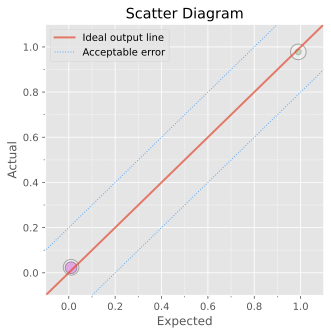

In [7]:
net.scatter()